# Trans-Effects 

Perform t-tests comparing the proteomic values for each gene NOT in the event of the patients with the event against those without the event. This should result in a giant table of pvalues and test_statitics. We will evaluate these results in preparation for GSEA.

## setup

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cptac
from scipy import stats
from utils import *
import cptac.utils as cptac_utils

In [2]:
luad = cptac.Luad()
hnscc = cptac.Hnscc()
ovarian = cptac.Ovarian()
colon = cptac.Colon()
brca = cptac.Brca()
lscc = cptac.Lscc()

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py, line 2)


version 3scc v3.2.......                    


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py, line 6)


In [23]:
proteomics = {
    'luad': luad.get_proteomics(),
    'hnscc': hnscc.get_proteomics(),
    'ovarian': ovarian.get_proteomics(),
    'colon': colon.get_proteomics(),
    'brca': brca.get_proteomics(),
    'lscc': lscc.get_proteomics()
}

## Append gene locations

In [24]:
locations = get_gene_locations()

In [25]:
locations

,,chromosome,start_bp,end_bp,arm
Name,Database_ID,,,,
SPTLC1P3,NaN,6,63227485.0,63227743.0,q
LLGL1,ENSG00000131899.6,17,18225635.0,18244875.0,p
DUX4L1,NaN,4,190084412.0,190085686.0,q
RBM18,ENSG00000119446.9,9,122237622.0,122264840.0,q
KRT18P53,NaN,X,545236.0,545352.0,p
...,...,...,...,...,...
PRPF38B,NaN,1,108692310.0,108702928.0,p
OR7E29P,NaN,3,125712139.0,125713045.0,q
TK1,ENSG00000167900.11,17,78174091.0,78187233.0,q


In [26]:
for cancer_type in proteomics.keys():
    df = proteomics[cancer_type]
    df = df.transpose()
    if not isinstance(df.index, pd.MultiIndex):
        new_df = df.join(locations.droplevel(1))
        new_df.drop_duplicates(inplace=True)
        proteomics[cancer_type] = new_df.dropna()
    else:
        new_df = df.join(locations)
        new_df.drop_duplicates(inplace=True)
        proteomics[cancer_type] = new_df.dropna()

## Remove proteins in event

In [27]:
CHROMOSOME = '8'
ARM = 'p'

In [28]:
for cancer_type in proteomics.keys():
    df = proteomics[cancer_type]
    df = df[(df.arm != ARM) | (df.chromosome != CHROMOSOME)]
    df.drop(['chromosome', 'start_bp', 'end_bp', 'arm'], axis=1, inplace=True)
    proteomics[cancer_type] = df

C:\Users\chels\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Append Event Data

In [29]:
EVENT_COLUMN = 'loss_event'
EXCLUDE_COLUMNS = 'gain_event'

In [31]:
has_event = dict()
for cancer_type in proteomics.keys():
    df = proteomics[cancer_type]
    df = df.transpose()
    event = pd.read_csv(f'{cancer_type}_has_event.tsv', sep='\t', index_col=0)
    if EXCLUDE_COLUMNS:
        event.drop(EXCLUDE_COLUMNS, axis=1, inplace=True)
    event.index.rename('Name')
    df = df.join(event)
    df = df.dropna(subset=[EVENT_COLUMN])
    has_event[cancer_type] = df[EVENT_COLUMN]
    proteomics[cancer_type] = df

C:\Users\chels\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


## Run T-Tests

In [11]:
# # Look into the wrap t-test (email Lindsey)
# def t_test(col, event):
#     has_event = col[event]
#     invert_list = [not x for x in event]
#     no_event = col[invert_list]
#     event_avg = has_event.mean()
#     no_event_avg = no_event.mean()
#     stat, pvalue = stats.ttest_ind(has_event, no_event)
#     return(event_avg - no_event_avg, pvalue)

In [36]:
results_df = None
for cancer_type in proteomics.keys():
    prot_df = proteomics[cancer_type]
    results = cptac_utils.wrap_ttest(prot_df, EVENT_COLUMN, return_all=True)
    results.set_index('Comparison', inplace=True)
    if isinstance(results.index[0], tuple):
        results[['Name', f'{cancer_type}_Database_ID']] = pd.DataFrame(results.index.values.tolist(), index=results.index)
        results.set_index(['Name', f'{cancer_type}_Database_ID'], inplace=True)
    else:
        results.index.name='Name'
    results.rename(columns={'P_Value': f'{cancer_type}_pvalue'}, inplace=True)
    if results_df is None:
        results_df = results
    else:
        results_df = results_df.join(results)

                                                             luad_pvalue
Name    luad_Database_ID                                                
EGFR    NP_005219.2|NP_001333829.1|NP_001333828.1|NP_00...  7.736386e-07
NUP50   NP_009103.2|NP_705931.1                             1.060132e-06
MTMR6   NP_004676.3                                         1.088433e-06
CNOT8   NP_001288002.1|NP_001288003.1|NP_001288004.1|NP...  2.746613e-06
RASGRP2 NP_001092140.1|NP_001305327.1                       4.686800e-06
...                                                                  ...
URI1    NP_003787.2|NP_001239570.1                          9.986303e-01
ANOS1   NP_000207.2                                         9.988259e-01
RBP1    NP_002890.2|NP_001124464.1|NP_001124465.1           9.988656e-01
NENF    NP_037481.1                                         9.989554e-01
CIAO1   NP_004795.1                                         9.992932e-01

[6901 rows x 1 columns]
        hnscc_pvalue
Name 

                                                                                                                          luad_pvalue  \
Name    luad_Database_ID                                   ovarian_Database_ID brca_Database_ID                                         
A1BG    NP_570602.2                                        NP_570602           NP_570602.2                                   0.037534   
A2M     NP_000005.2|NP_001334353.1|NP_001334354.1|K4JDR... NP_000005           NP_000005.2                                   0.100008   
AAAS    NP_056480.1|NP_001166937.1                         NP_056480           NP_056480.1|NP_001166937.1                    0.045270   
AACS    NP_076417.2|NP_001306769.1|NP_001306768.1          NP_076417           NP_076417.2|NP_001306769.1|NP_001306768.1     0.746112   
AAGAB   NP_078942.3|NP_001258814.1                         NP_078942           NP_078942.3|NP_001258815.1                    0.435497   
...                                      

In [37]:
results_df

,,,,,luad_pvalue,hnscc_pvalue,ovarian_pvalue,colon_pvalue,brca_pvalue,lscc_pvalue
Name,brca_Database_ID,luad_Database_ID,ovarian_Database_ID,lscc_Database_ID,,,,,,
A1BG,NP_570602.2,NP_570602.2,NP_570602,NP_570602.2,0.037534,0.601315,0.041569,0.439631,0.685027,0.144705
A2M,NP_000005.2,NP_000005.2|NP_001334353.1|NP_001334354.1|K4JDR8|K4JBA2|K4JB97,NP_000005,NP_000005.2|NP_001334353.1|NP_001334354.1,0.100008,0.409582,0.179498,0.521970,0.257230,0.325102
AAAS,NP_056480.1|NP_001166937.1,NP_056480.1|NP_001166937.1,NP_056480,NP_056480.1|NP_001166937.1,0.045270,0.648547,0.548131,0.212277,0.642219,0.704721
AACS,NP_076417.2|NP_001306769.1|NP_001306768.1,NP_076417.2|NP_001306769.1|NP_001306768.1,NP_076417,NP_076417.2|NP_001306769.1|NP_001306768.1,0.746112,0.687168,0.266056,0.243228,0.718361,0.080857
AAGAB,NP_078942.3|NP_001258815.1,NP_078942.3|NP_001258814.1,NP_078942,NP_078942.3|NP_001258814.1,0.435497,0.722371,0.534677,0.317132,0.035007,0.286129
...,...,...,...,...,...,...,...,...,...,...
ZSCAN18,NP_001139014.1|NP_001139015.1,NP_001139014.1|NP_001139015.1|NP_001139016.1,NaN,NP_001139014.1|NP_001139015.1|NP_001139016.1,0.063866,NaN,NaN,NaN,0.734685,0.585021
ZW10,NP_004715.1,NP_004715.1,NP_004715,NP_004715.1,0.604071,0.243313,0.676894,0.689958,0.104282,0.077858
ZYG11B,NP_078922.1,NP_078922.1,NP_078922,NP_078922.1,0.000261,0.706097,0.038421,NaN,0.825559,0.309742


## Append diff data

In [40]:
def get_diff(col, event):
    has_event = col[event]
    invert_list = [not x for x in event]
    no_event = col[invert_list]
    event_avg = has_event.mean()
    no_event_avg = no_event.mean()
    return event_avg - no_event_avg

In [51]:
diff_df = None
for cancer_type in proteomics.keys():
    df = proteomics[cancer_type]
    df = df.drop(EVENT_COLUMN, axis=1)
    results = df.apply(lambda x: get_diff(x, has_event[cancer_type]))
    df = pd.DataFrame(results)
    if isinstance(df.index[0], tuple):
        df[['Name', f'{cancer_type}_Database_ID']] = pd.DataFrame(df.index.values.tolist(), index=df.index)
        df.set_index(['Name', f'{cancer_type}_Database_ID'], inplace=True)
    else:
        df.index.name='Name'
    df.rename(columns={0: f'{cancer_type}_diff'}, inplace=True)
    if diff_df is None:
        diff_df = df
    else:
        diff_df = diff_df.join(df)

Index([                                                  ('A1BG', 'NP_570602.2'),
       ('A2M', 'NP_000005.2|NP_001334353.1|NP_001334354.1|K4JDR8|K4JBA2|K4JB97'),
                                          ('AAAS', 'NP_056480.1|NP_001166937.1'),
                           ('AACS', 'NP_076417.2|NP_001306769.1|NP_001306768.1'),
                                         ('AAGAB', 'NP_078942.3|NP_001258814.1'),
        ('AAMDC', 'NP_001303889.1|NP_001350493.1|NP_001303886.1|NP_001303887.1'),
                                          ('AAMP', 'NP_001289474.1|NP_001078.2'),
                                                      ('AAR2', 'NP_001258803.1'),
                                                        ('AARS2', 'NP_065796.1'),
                         ('AARSD1', 'NP_001248363.1|NP_001129514.2|NP_079543.1'),
       ...
                                        ('ZNHIT6', 'NP_060423.3|NP_001164141.1'),
                                                        ('ZNRF2', 'NP_667339.1'),
     

                                                        0  \
(A1BG, NP_570602.2)                                  A1BG   
(A2M, NP_000005.2|NP_001334353.1|NP_001334354.1)      A2M   
(A2ML1, NP_653271.2|NP_001269353.1)                 A2ML1   
(AAAS, NP_056480.1|NP_001166937.1)                   AAAS   
(AACS, NP_076417.2|NP_001306769.1|NP_001306768.1)    AACS   
...                                                   ...   
(ZW10, NP_004715.1)                                  ZW10   
(ZWILCH, NP_060445.3|NP_001274750.1)               ZWILCH   
(ZYG11B, NP_078922.1)                              ZYG11B   
(ZYX, NP_001010972.1|NP_001349712.1)                  ZYX   
(ZZEF1, NP_055928.3)                                ZZEF1   

                                                                                           1  
(A1BG, NP_570602.2)                                                              NP_570602.2  
(A2M, NP_000005.2|NP_001334353.1|NP_001334354.1)   NP_000005.2|NP_001334353.1

In [57]:
results_df = results_df.join(diff_df)

In [13]:
results_df.to_csv("8p_transeffects.tsv", sep='\t')

## Find common sig genes

In [14]:
def count_low_pvalues(row):
    count = 0
    for cancer_type in proteomics.keys():
        if row[f'{cancer_type}_pvalue'] < 0.1:
            count += 1
    return str(count)
#     return ((row['luad_pvalue'] < 0.1) & (row['ovarian_pvalue'] < 0.1) & (row['hnscc_pvalue'] < 0.1) & (row['colon_pvalue'] < 0.1) & (row['brca_pvalue'] < 0.1) & (row['lscc_pvalue'] < 0.1))

In [15]:
results_df['count'] = results_df.apply(lambda x: count_low_pvalues(x), axis=1)

## Make Volcano Plot

In [62]:
# Get pvalue columns
pvalues_cols = [x for x in list(results_df.columns) if x.endswith('pvalue')]
# Log transform each pvalue column
for col in pvalues_cols:
    results_df[f'{col}_log'] = results_df[col].apply(lambda x: -np.log10(x))# Add row of counts


In [63]:
results_df

,,,,,luad_pvalue,hnscc_pvalue,ovarian_pvalue,colon_pvalue,brca_pvalue,lscc_pvalue,luad_pvalue_log,hnscc_pvalue_log,ovarian_pvalue_log,colon_pvalue_log,brca_pvalue_log,lscc_pvalue_log,luad_diff,hnscc_diff,ovarian_diff,colon_diff,brca_diff,lscc_diff
Name,brca_Database_ID,luad_Database_ID,ovarian_Database_ID,lscc_Database_ID,,,,,,,,,,,,,,,,,,
A1BG,NP_570602.2,NP_570602.2,NP_570602,NP_570602.2,0.037534,0.601315,0.041569,0.439631,0.685027,0.144705,1.425573,0.220898,1.381232,0.356912,0.164292,0.839516,-0.442692,-0.037599,-0.294055,-0.119042,-0.102606,0.312395
A2M,NP_000005.2,NP_000005.2|NP_001334353.1|NP_001334354.1|K4JDR8|K4JBA2|K4JB97,NP_000005,NP_000005.2|NP_001334353.1|NP_001334354.1,0.100008,0.409582,0.179498,0.521970,0.257230,0.325102,0.999967,0.387659,0.745940,0.282354,0.589678,0.487981,-0.461877,-0.094712,-0.244195,-0.081407,0.331652,0.301145
AAAS,NP_056480.1|NP_001166937.1,NP_056480.1|NP_001166937.1,NP_056480,NP_056480.1|NP_001166937.1,0.045270,0.648547,0.548131,0.212277,0.642219,0.704721,1.344188,0.188059,0.261115,0.673097,0.192317,0.151983,0.219718,0.020226,0.030730,-0.100606,0.049927,-0.037585
AACS,NP_076417.2|NP_001306769.1|NP_001306768.1,NP_076417.2|NP_001306769.1|NP_001306768.1,NP_076417,NP_076417.2|NP_001306769.1|NP_001306768.1,0.746112,0.687168,0.266056,0.243228,0.718361,0.080857,0.127196,0.162937,0.575027,0.613986,0.143657,1.092285,-0.103594,0.039000,0.132034,0.089959,0.109607,-0.527445
AAGAB,NP_078942.3|NP_001258815.1,NP_078942.3|NP_001258814.1,NP_078942,NP_078942.3|NP_001258814.1,0.435497,0.722371,0.534677,0.317132,0.035007,0.286129,0.361015,0.141240,0.271908,0.498760,1.455845,0.543438,-0.119763,-0.026190,0.049414,-0.078345,0.367299,-0.174586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN18,NP_001139014.1|NP_001139015.1,NP_001139014.1|NP_001139015.1|NP_001139016.1,NaN,NP_001139014.1|NP_001139015.1|NP_001139016.1,0.063866,NaN,NaN,NaN,0.734685,0.585021,1.194728,NaN,NaN,NaN,0.133899,0.232829,0.396487,NaN,NaN,NaN,-0.083726,0.130451
ZW10,NP_004715.1,NP_004715.1,NP_004715,NP_004715.1,0.604071,0.243313,0.676894,0.689958,0.104282,0.077858,0.218912,0.613835,0.169480,0.161177,0.981790,1.108697,0.068829,-0.041646,0.019092,0.016886,-0.182520,-0.174501
ZYG11B,NP_078922.1,NP_078922.1,NP_078922,NP_078922.1,0.000261,0.706097,0.038421,NaN,0.825559,0.309742,3.582652,0.151135,1.415431,NaN,0.083252,0.509001,0.403674,0.018758,0.122501,NaN,0.025123,0.120766


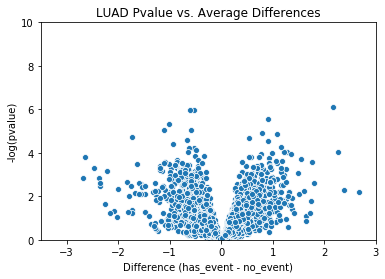

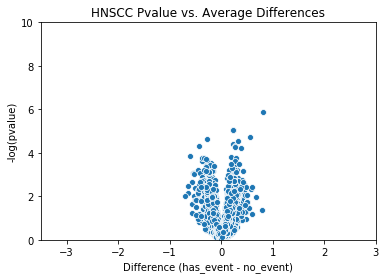

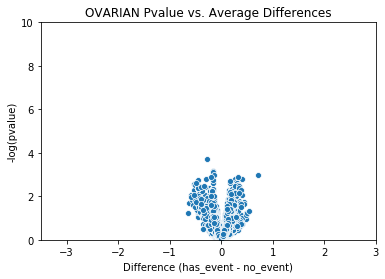

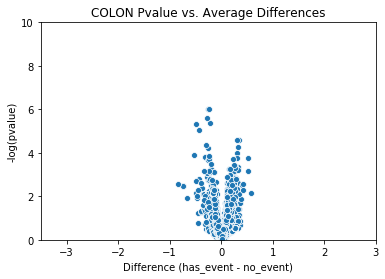

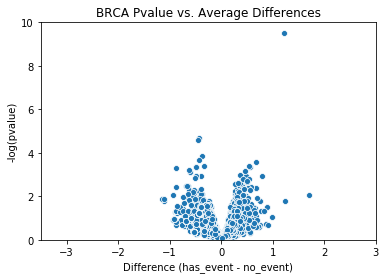

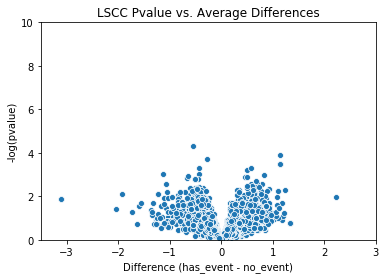

In [64]:
for cancer_type in proteomics.keys():
    plt.figure()
    sns.scatterplot(x=f'{cancer_type}_diff', y=f'{cancer_type}_pvalue_log', data=results_df)
    plt.xlim(-3.5, 3)
    plt.ylim(0,10)
    plt.xlabel("Difference (has_event - no_event)")
    plt.ylabel("-log(pvalue)")
    plt.title(f'{cancer_type.upper()} Pvalue vs. Average Differences')
    plt.show()

In [65]:
results_df

,,,,,luad_pvalue,hnscc_pvalue,ovarian_pvalue,colon_pvalue,brca_pvalue,lscc_pvalue,luad_pvalue_log,hnscc_pvalue_log,ovarian_pvalue_log,colon_pvalue_log,brca_pvalue_log,lscc_pvalue_log,luad_diff,hnscc_diff,ovarian_diff,colon_diff,brca_diff,lscc_diff
Name,brca_Database_ID,luad_Database_ID,ovarian_Database_ID,lscc_Database_ID,,,,,,,,,,,,,,,,,,
A1BG,NP_570602.2,NP_570602.2,NP_570602,NP_570602.2,0.037534,0.601315,0.041569,0.439631,0.685027,0.144705,1.425573,0.220898,1.381232,0.356912,0.164292,0.839516,-0.442692,-0.037599,-0.294055,-0.119042,-0.102606,0.312395
A2M,NP_000005.2,NP_000005.2|NP_001334353.1|NP_001334354.1|K4JDR8|K4JBA2|K4JB97,NP_000005,NP_000005.2|NP_001334353.1|NP_001334354.1,0.100008,0.409582,0.179498,0.521970,0.257230,0.325102,0.999967,0.387659,0.745940,0.282354,0.589678,0.487981,-0.461877,-0.094712,-0.244195,-0.081407,0.331652,0.301145
AAAS,NP_056480.1|NP_001166937.1,NP_056480.1|NP_001166937.1,NP_056480,NP_056480.1|NP_001166937.1,0.045270,0.648547,0.548131,0.212277,0.642219,0.704721,1.344188,0.188059,0.261115,0.673097,0.192317,0.151983,0.219718,0.020226,0.030730,-0.100606,0.049927,-0.037585
AACS,NP_076417.2|NP_001306769.1|NP_001306768.1,NP_076417.2|NP_001306769.1|NP_001306768.1,NP_076417,NP_076417.2|NP_001306769.1|NP_001306768.1,0.746112,0.687168,0.266056,0.243228,0.718361,0.080857,0.127196,0.162937,0.575027,0.613986,0.143657,1.092285,-0.103594,0.039000,0.132034,0.089959,0.109607,-0.527445
AAGAB,NP_078942.3|NP_001258815.1,NP_078942.3|NP_001258814.1,NP_078942,NP_078942.3|NP_001258814.1,0.435497,0.722371,0.534677,0.317132,0.035007,0.286129,0.361015,0.141240,0.271908,0.498760,1.455845,0.543438,-0.119763,-0.026190,0.049414,-0.078345,0.367299,-0.174586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN18,NP_001139014.1|NP_001139015.1,NP_001139014.1|NP_001139015.1|NP_001139016.1,NaN,NP_001139014.1|NP_001139015.1|NP_001139016.1,0.063866,NaN,NaN,NaN,0.734685,0.585021,1.194728,NaN,NaN,NaN,0.133899,0.232829,0.396487,NaN,NaN,NaN,-0.083726,0.130451
ZW10,NP_004715.1,NP_004715.1,NP_004715,NP_004715.1,0.604071,0.243313,0.676894,0.689958,0.104282,0.077858,0.218912,0.613835,0.169480,0.161177,0.981790,1.108697,0.068829,-0.041646,0.019092,0.016886,-0.182520,-0.174501
ZYG11B,NP_078922.1,NP_078922.1,NP_078922,NP_078922.1,0.000261,0.706097,0.038421,NaN,0.825559,0.309742,3.582652,0.151135,1.415431,NaN,0.083252,0.509001,0.403674,0.018758,0.122501,NaN,0.025123,0.120766
